In [3]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set_theme()

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from collections import Counter
from nltk.corpus import stopwords

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format='{:.2f}'.format

## Data Import ##

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Text Cleaning ##

### Remove URL ###

In [13]:
train= train.drop('url', axis=1)
train.head()

,headlines,description,content,category
0,RBI revises definition of politically-exposed persons for KYC purpose,"The central bank has also asked chairpersons and chief executives of banks and other financial services, which are into lending business, to make the changes effective immediately.","The Reserve Bank of India (RBI) has changed the definition of Politically-Exposed Persons (PEPs) under its norms, a move that will make it easier for those individuals to carry out various banking transactions, including availing loans.\r\nCertain changes have been made in the RBI’s Know Your Customer (KYC) norms.\r\nThe earlier norms pertaining to PEPs were open-ended and there was a lack of clarity on the definition, apparently leading to issues for bankers, parliamentarians and others. There were also concerns in certain quarters that PEPs were finding it difficult to get loans or open bank accounts.\r\nADVERTISEMENT\r\nIn the amended KYC master direction, the central bank defines PEPs as “individuals who are or have been entrusted with prominent public functions by a foreign country, including the heads of states/governments, senior politicians, senior government or judicial or military officers, senior executives of state-owned corporations and important political party officials”. The new rules also include a person who is entrusted by a foreign country with a public function.\r\nBank accounts of PEPs have additional KYC norms under the current provisions and special due diligence has to be undertaken by a senior bank official. A sub-clause in the master direction in KYC norms issued by way of a circular on February 25, 2016 has been removed by the central bank.\r\nThe central bank has also asked chairpersons and chief executives of banks and other financial services, which are into lending business, to make the changes effective immediately.\r\nLast year, the Centre amended the Prevention of Money Laundering Act (PMLA) to introduce more disclosures for non-government organisations by reporting entities.",business
1,NDTV Q2 net profit falls 57.4% to Rs 5.55 crore impacted by lower revenue and higher expenses,NDTV's consolidated revenue from operations was Rs 95.55 crore as against Rs 105.8 crore in the year-ago period.,"Broadcaster New Delhi Television Ltd on Monday reported a 57.4 per cent decline in consolidated profit after tax at Rs 5.55 crore in the September quarter, impacted by lower revenue and higher expenses.\r\nThe company had posted a consolidated net profit of Rs 13.03 crore in the same quarter last fiscal, New Delhi Television Ltd (NDTV) said in a regulatory filing.\r\nConsolidated revenue from operations was Rs 95.55 crore as against Rs 105.8 crore in the year-ago period, it added.\r\nADVERTISEMENT\r\nTotal expenses were higher at Rs 93.48 crore as compared to Rs 91.93 crore a year ago, the company said.\r\nIn the second quarter, there was a slight bullishness in advertisement spend despite the muted economic environment, it added.\r\nNDTV said it launched two regional channels ‘NDTV Madhya Pradesh/Chhattisgarh’ and ‘NDTV Rajasthan’ in the second quarter (Q2).\r\n“With its focus on expansion and growth, NDTV expects to launch more regional channels in the near future,” the company said.",business
2,"Akasa Air ‘well capitalised’, can grow much faster: CEO Vinay Dube","The initial share sale will be open for public subscription during July 17-19. The bidding for anchor investors will open on July 14, according to the company.","Homegrown server maker Netweb Technologies India on Thursday said it has fixed a price band of Rs 475-500 per share for its Rs 631-crore initial public offering (IPO).\r\nThe initial share sale will be open for public subscription during July 17-19. The bidding for anchor investors will open on July 14, according to the company.\r\nThe IPO comprises a fresh issue of equity shares worth Rs 206 crore and an offer-for-sale (OFS) of 85 lakh equity shares by promoters.\r\nADVERTISEMENT\r\nThose sell

In [14]:
test = test.drop('url', axis=1)
test.head()

headlines  \
0                            NLC India wins contract for power supply to Rajasthan at Rs 2.64 per unit   
1                    SBI Clerk prelims exams dates announced; admit card from December 27 at sbi.co.in   
2  Golden Globes: Michelle Yeoh, Will Ferrell, Angela Bassett will present awards. Here’s what to know   
3                                     OnePlus Nord 3 at Rs 27,999 as part of new price cut: Here’s how   
4                         Adani family’s partners used ‘opaque’ funds to invest in its stocks : Report   

                                                                                                                                                                                                                                             description  \
0                                                                                        State-owned firm NLC India Ltd (NLCIL) on Monday said it has emerged as the successful bidder for supply of power to Rajasthan at a tariff of Rs 2.64 per unit.   
1                                                                       SBI Clerk Prelims Exam: The SBI Clerk prelims exam 2024 will be tentatively held on January 5, 6, 11 and 12. The schedule was released at the official SBI website -- sbi.co.in.   
2                                                                         Barbie is the top nominee this year, followed closely by Oppenheimer. The films reflect one unique aspect of the Globes — they split the top film winners into two categories.   
3                                                                                                                                                                                       New deal makes the OnePlus Nord 3 an easy purchase under Rs 30k.   
4  Citing review of files from multiple tax havens and internal Adani Group emails, nonprofit media organization OCCRP said its investigation found at least two cases where the investors bought and sold Adani stock through such offshore structures.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [5]:
y_train = train['category']
y_test = test['category']
X_train = train.drop('category', axis=1)
X_test = test.drop('category', axis=1)

### Remove all punctuation ###

In [6]:
datasets = [X_train, X_test]

In [32]:
def remove_punctuation_and_special_characters(text):
  """Removes punctuation and special characters from a string.

  Args:
    text: The input string.

  Returns:
    The string with punctuation and special characters removed.
  """
  pattern = r'[^\w\s]'  # Matches any character that is NOT a word character (\w) or whitespace (\s)
  return re.sub(pattern, ' ', text)

In [33]:
def clean_dataframe_column_string(df, column_name):
    df[column_name] = df[column_name].apply(remove_punctuation_and_special_characters)
    return df

In [34]:
for df in datasets:
    for column in df.columns:
        clean_dataframe_column_string(df, column)

NameError: name 'datasets' is not defined

In [10]:
X_train['headlines'] = X_train['headlines'].astype(str)
X_train['description'] = X_train['description'].astype(str)
X_train['content'] = X_train['content'].astype(str)

X_test['headlines'] = X_test['headlines'].astype(str)
X_test['description'] = X_test['description'].astype(str)
X_test['content'] = X_test['content'].astype(str)

X_train['headlines'] = X_train['headlines'].fillna('')  # Replace NaN with empty string
X_train['description'] = X_train['description'].fillna('')
X_train['content'] = X_train['content'].fillna('')

X_test['headlines'] = X_test['headlines'].fillna('')
X_test['description'] = X_test['description'].fillna('')
X_test['content'] = X_test['content'].fillna('')

### CountVectorizer ###

In [11]:
def vectorize_news_data(X_train, X_test): # Added train_df argument
    """Vectorizes heading, description, and body separately and combines them.

    Args:
      X_train: Training data DataFrame (containing heading, description, body).
      X_test: Optional test data DataFrame. If provided, it will be transformed using the vectorizers fitted on the training data.

    Returns:
        A tuple containing:
        - X_train_combined: Combined sparse matrix for training data.
        - X_test_combined: Combined sparse matrix for test data (if X_test is provided), otherwise None.
    """
    vectorizers = {}
    transformed_features_train = []
    transformed_features_test = []

    features = ['headlines', 'description', 'content']  # Features to vectorise

    for feature in features:
        vectorizers[feature] = CountVectorizer(stop_words='english', min_df=2, max_df=0.5)

        vectorizers[feature].fit(X_train[feature]) # Fit on training data

        transformed_train = vectorizers[feature].transform(X_train[feature])
        transformed_features_train.append(transformed_train)

        transformed_test = vectorizers[feature].transform(X_test[feature]) # Transform test data
        transformed_features_test.append(transformed_test)

    X_train_combined = hstack(transformed_features_train)
    X_test_combined = hstack(transformed_features_test)
    return X_train_combined, X_test_combined

In [12]:
X_train_combined, X_test_combined = vectorize_news_data(X_train, X_test)

# EDA

In [18]:
data = pd.concat([test, train], axis=0)

In [19]:
data.shape

(7520, 4)

In [20]:
data.head(10)

headlines  \
0                                                    NLC India wins contract for power supply to Rajasthan at Rs 2.64 per unit   
1                                            SBI Clerk prelims exams dates announced; admit card from December 27 at sbi.co.in   
2                          Golden Globes: Michelle Yeoh, Will Ferrell, Angela Bassett will present awards. Here’s what to know   
3                                                             OnePlus Nord 3 at Rs 27,999 as part of new price cut: Here’s how   
4                                                 Adani family’s partners used ‘opaque’ funds to invest in its stocks : Report   
5                                  Samsung’s first budget Galaxy foldable might arrive next year: Reported to cost around $500   
6                                                                Samsung races Apple to develop noninvasive glucose monitoring   
7                 India vs Australia: After Ravindra Jadeja, Rohit Sharma ensures India seizes control of Nagpur Test on Day 1   
8                                                                     Punjab schools to reopen today: State education minister   
9  Shah Rukh Khan jumped at chance to do a small role in Wagle Ki Duniya, recalls Aanjjan Srivastav: ‘He was on another level’   

                                                                                                                                                                                                                                             description  \
0                                                                                        State-owned firm NLC India Ltd (NLCIL) on Monday said it has emerged as the successful bidder for supply of power to Rajasthan at a tariff of Rs 2.64 per unit.   
1                                                                       SBI Clerk Prelims Exam: The SBI Clerk prelims exam 2024 will be tentatively held on January 5, 6, 11 and 12. The schedule was released at the official SBI website -- sbi.co.in.   
2                                                                         Barbie is the top nominee this year, followed closely by Oppenheimer. The films reflect one unique aspect of the Globes — they split the top film winners into two categories.   
3                                                                                                                                                                                       New deal makes the OnePlus Nord 3 an easy purchase under Rs 30k.   
4  Citing review of files from multiple tax havens and internal Adani Group emails, nonprofit media organization OCCRP said its investigation found at least two cases where the investors bought and sold Adani stock through such offshore structures.   
5                                                                                                                                                              Samsung's first affordable foldable smartphone could be priced similar to the Galaxy A54.   
6                                                                                                               Samsung is aiming for noninvasive continuous glucose monitoring and blood pressure tracking in race against Apple's health tech efforts.   
7                                                                                                                                                       IND vs AUS: On a slow turner, spinners shut Australia to 177 as skipper leads hosts strong reply   
8                                                                                                                        Earlier, the  Punjab government had ordered closure of all schools till July 13 in view of the incessant rainfall in the state.   
9                                                                                                                     Aanjjan Srivastav and Shah Rukh Khan worked toge

In [22]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 headlines      0
description    0
content        0
category       0
dtype: int64


There are no missing values in the dataset.

<ipython-input-24-94578788968d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=data['category'], order=data['category'].value_counts().index, palette='viridis')


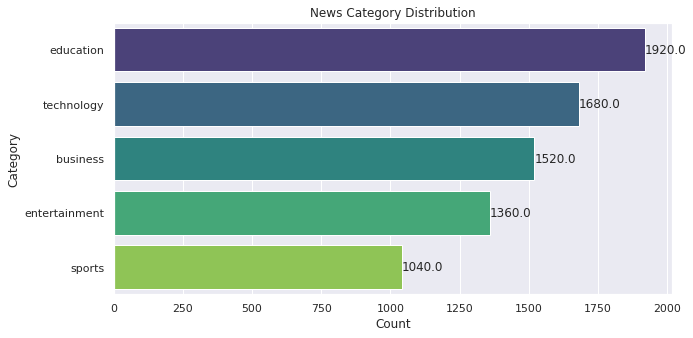

In [24]:
# Category distribution
plt.figure(figsize=(10, 5))
ax = sns.countplot(y=data['category'], order=data['category'].value_counts().index, palette='viridis')
plt.title("News Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")

# Annotate counts on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center')

plt.show()

This bar chart shows how many articles belong to each category. Some categories have significantly more articles than others, it indicates an imbalance in the dataset.

In [25]:
# Text length analysis
data['headline_length'] = data['headlines'].apply(len)
data['description_length'] = data['description'].apply(len)
data['content_length'] = data['content'].apply(len)

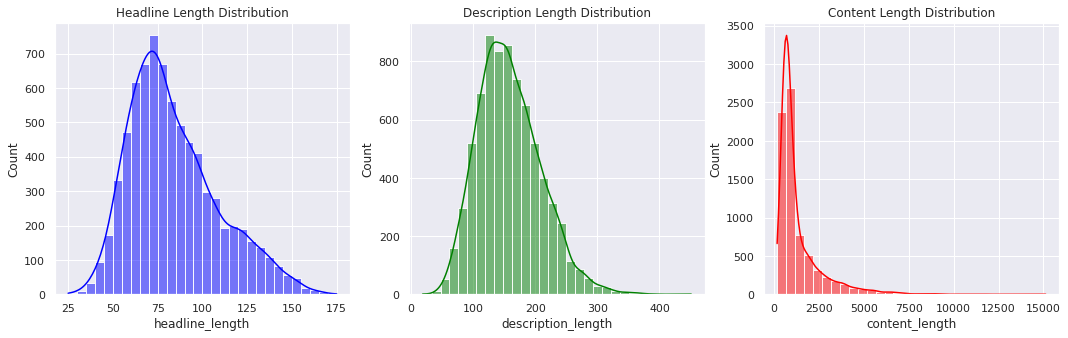

In [27]:
# Plot text length distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data['headline_length'], bins=30, ax=axes[0], kde=True, color='blue')
axes[0].set_title("Headline Length Distribution")
sns.histplot(data['description_length'], bins=30, ax=axes[1], kde=True, color='green')
axes[1].set_title("Description Length Distribution")
sns.histplot(data['content_length'], bins=30, ax=axes[2], kde=True, color='red')
axes[2].set_title("Content Length Distribution")
plt.show()

Headline Length Distribution: This histogram shows how long the article headlines typically are.

Description Length Distribution: This shows the variation in summary lengths.

Content Length Distribution: This shows the length distribution of full articles.

Content Length Distribution is heavily skewed to the right (shows there are too many very short texts), it indicates noisy data.

In [28]:
# Basic word frequency analysis
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/seboo001/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
stop_words = set(stopwords.words('english'))
all_words = ' '.join(data['content']).lower().split()
filtered_words = [word for word in all_words if word.isalpha() and word not in stop_words]
word_counts = Counter(filtered_words)

In [30]:
# Top 20 most common words
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

<ipython-input-31-c2880ecb2ae3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='magma')


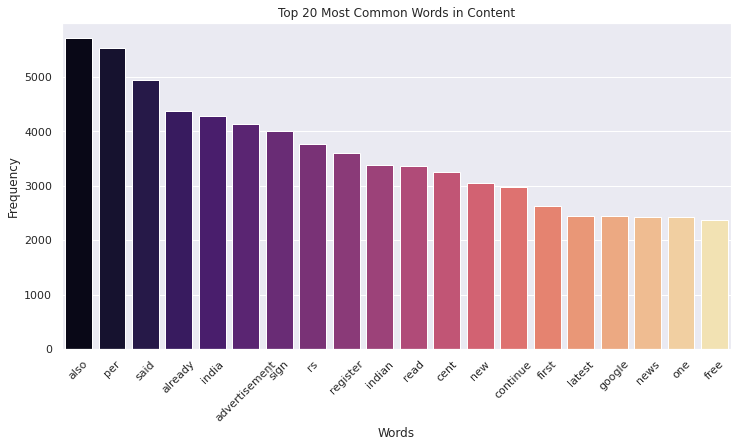

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='magma')
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in Content")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

This bar chart displays the most frequent words in the news articles (excluding common stopwords like "the," "and," etc.).Words that appear frequently might be useful as keywords or topics for classification.